In [1]:
import mim_control_cpp
from mim_control.robot_centroidal_controller import RobotCentroidalController
from mim_data_utils import DataReader
from scipy.spatial.transform import Rotation
from dynamic_graph_head import ThreadHead, SimHead, SimVicon, HoldPDController
from robot_properties_solo.solo8wrapper import Solo8Robot, Solo8Config
from bullet_utils.env import BulletEnvWithGround
import pinocchio as pin
import matplotlib.pylab as plt
import numpy as np
np.set_printoptions(suppress=True, precision=5, sign=' ')
plt.rcParams['figure.dpi'] = 144  # default 72.0


def get_target(*args):
    angle_adjust = np.array([1, -2, 1, -2, -1, 2, -1, 2]) * np.pi
    if len(args) == 1:
        return get_target(*args[0])
    elif len(args) == 4:
        return np.array([args[0], args[0], args[1], args[1], args[2], args[2], args[3], args[3]]) * angle_adjust
    elif len(args) == 8:
        return np.array([args[0], args[1], args[2], args[3], args[4], args[5], args[6], args[7]]) * angle_adjust

    return np.zeros(8)

In [2]:
class MyController:
    def __init__(self, head, Kp, Kd, with_sliders=False, num=250):
        self.head = head
        self.Kp = Kp
        self.Kd = Kd

        self.slider_scale = np.pi
        self.with_sliders = with_sliders

        self.joint_positions = head.get_sensor('joint_positions')
        self.joint_velocities = head.get_sensor('joint_velocities')

        if with_sliders:
            self.slider_positions = head.get_sensor('slider_positions')

        # variables for trotting
        leg_down = 0.1
        leg_up = 0.2
        self.Targets = (
            get_target(leg_down, leg_up, leg_up, leg_down),
            get_target(leg_up, leg_down, leg_down, leg_up),
        )
        self.i_Targets = 0
        self.L = None
        self.i_L = 0
        self.num = num

        # GRF z
        # self.fz = np.empty(4)
        # self.fk = np.empty(3)

        # imu
        self.imu = np.empty(6)

    def warmup(self, thread_head):
        self.zero_pos = self.joint_positions.copy()

        if self.with_sliders:
            self.slider_zero_pos = self.map_sliders(self.slider_positions)

    def go_zero(self):
        # TODO: Make this an interpolation.
        self.zero_pos = np.zeros_like(self.zero_pos)

        if self.with_sliders:
            self.slider_zero_pos = self.map_sliders(self.slider_positions)

    def map_sliders(self, sliders):
        sliders_out = np.zeros_like(self.joint_positions)
        if self.joint_positions.shape[0] == 8:
            slider_A = sliders[0]
            slider_B = sliders[1]
            for i in range(4):
                sliders_out[2 * i + 0] = slider_A
                sliders_out[2 * i + 1] = 2. * (1. - slider_B)

                if i >= 2:
                    sliders_out[2 * i + 0] *= -1
                    sliders_out[2 * i + 1] *= -1

        return sliders_out

    def _sim_imu(self, thread_head):
        head = thread_head.head
        self.imu[0:3] = Rotation.from_quat(
            head._sensor__vicon_base_position[3:7]).as_euler('xyz')
        self.imu[3:6] = head._sensor_imu_gyroscope  # angular rate

    def get_vicon(self, name1, name2=None):
        return np.hstack(thread_head.vicon.get_state(name1 + '/' + (name1 if name2 is None else name2)))
    
    def _vicon(self, thread_head):
#         self.vicon_leg_fr = self.get_vicon('solo8_fr', 'hopper_foot')
#         self.vicon_leg_hl = self.get_vicon('solo8_hl', 'hopper_foot')
#         self.vicon_leg_hr = self.get_vicon('solo8_hr', 'hopper_foot')
        self.vicon_solo = self.get_vicon('solo8v2')

    def _move(self, thread_head):
        # if self.with_sliders:
        #     self.des_position = self.slider_scale * (
        #         self.map_sliders(self.slider_positions) - self.slider_zero_pos
        #         ) + self.zero_pos
        # else:

        if self.L is None or self.i_L >= len(self.L):
            self.L = np.linspace(self.joint_positions,
                                    self.Targets[self.i_Targets], num=self.num)
            self.i_L = 0
            self.i_Targets = (self.i_Targets + 1) % len(self.Targets)

        self.des_position = self.L[self.i_L]
        self.i_L += 1           

    def _GRF(self, thread_head):
        head = thread_head.head
        pin_robot = head._robot.pin_robot
        vicon = thread_head.vicon.get_state('solo8v2/solo8v2')
        q = np.hstack((vicon[0], head.get_sensor('joint_positions')))
        v = np.hstack((vicon[1], head.get_sensor('joint_velocities')))
        pin_robot.computeJointJacobians(q)

        for i, endeff_name in enumerate(['FL_ANKLE', 'FR_ANKLE', 'HL_ANKLE', 'HR_ANKLE']):
            frame_id = robot.pin_robot.model.getFrameId(endeff_name)
            pin_robot.framePlacement(q, index=frame_id)
            J = pin_robot.getFrameJacobian(frame_id=frame_id, rf_frame=pin.ReferenceFrame.LOCAL_WORLD_ALIGNED)
            J_inv = np.linalg.pinv(J[:3][:,6+2*i:8+2*i].T) * -1
            h = robot.pin_robot.nle(q, v)
            F = np.hstack((np.zeros(6), thread_head.active_controllers[0].tau))
            self.fz[i] = (J_inv @ ((F - h)[6+2*i:8+2*i]))[2]            
        
        pin_robot.framesForwardKinematics(q)
        self.fk = pin_robot.data.oMf[pin_robot.model.getFrameId('HL_ANKLE')].translation
        
    def run(self, thread_head):
        self._move(thread_head)  # calculate des_position
        self._sim_imu(thread_head)  # simulate imu output
        self._vicon(thread_head)  # vicon objects
        # self._GRF(thread_head)  # calculate GRF

        self.tau = self.Kp * (self.des_position - self.joint_positions) - self.Kd * self.joint_velocities
#         self.tau = np.zeros(8)
        thread_head.head.set_control('ctrl_joint_torques', self.tau)
    
    
class ResetController:
    def __init__(self):
        pass

    def warmup(self, thread_head):
        pass

    def run(self, thread_head):
        self.tau = np.zeros(8)
        thread_head.head.set_control('ctrl_joint_torques', self.tau)

In [3]:
bullet_env = BulletEnvWithGround()
robot = Solo8Robot()
bullet_env.add_robot(robot)

In [4]:
head = SimHead(robot, vicon_name='solo8v2')
thread_head = ThreadHead(
    0.001,  # dt
    HoldPDController(head, 5, 0.05, True),  # safety controller
    head,  # head object
    [  # utils
        ('vicon', SimVicon(['solo8v2/solo8v2']))
    ],
    bullet_env  # env
)

In [5]:
# print(np.sum(np.array(robot.get_force()[1])[:, 2]))
# print(robot.get_force()[1])
# print(len(robot.get_force()[1]))

In [6]:
my_controller = MyController(head, 5, 0.05, with_sliders=False, num=650)

q0 = np.array(Solo8Config.initial_configuration)
q0[0] = 0.
q0[2] = 0.26
q0[-8:] = get_target(0.2, 0.2, 0.2, 0.2)

thread_head.head.reset_state(q0, Solo8Config.initial_velocity)

# thread_head.switch_controllers(my_controller)


def reset():
    thread_head.switch_controllers(ResetController())
    thread_head.sim_run(100)
    thread_head.switch_controllers(my_controller)


reset()

In [25]:
# thread_head.start_logging()

thread_head.sim_run(5000, sleep=False)

thread_head.stop_logging()

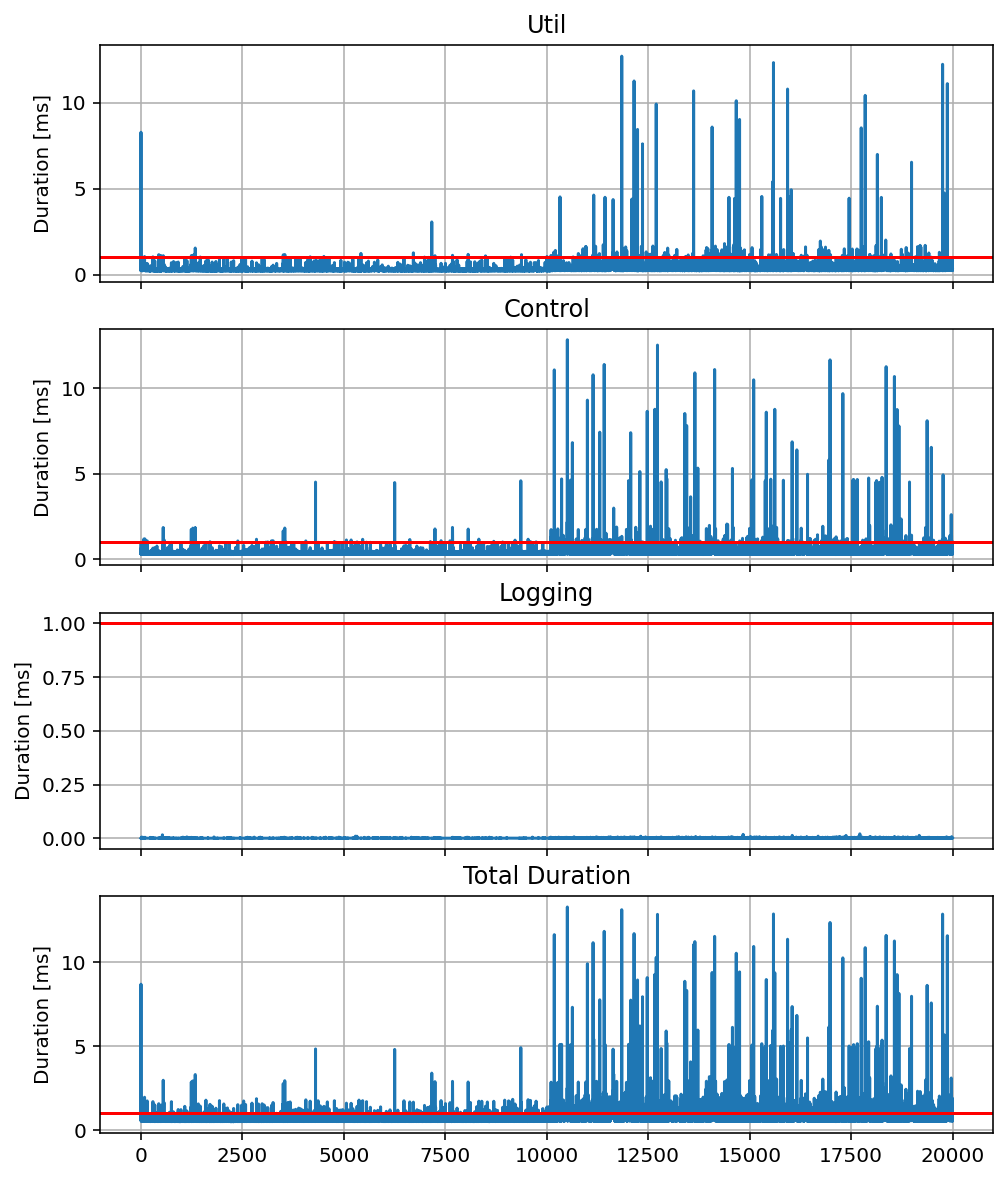

In [26]:
thread_head.plot_timing()  # Plot timing information.

In [9]:
reader = DataReader('2021-07-29_14-49-13.mds')

In [10]:
reader.data.keys()

dict_keys(['Kp', 'Kd', 'slider_scale', 'joint_positions', 'joint_velocities', 'i_Targets', 'i_L', 'num', 'fz', 'fk', 'zero_pos', 'des_position', 'vicon_solo', 'tau'])

In [13]:
F_z = np.empty((reader.data['q'].shape[0], 4))
forward_k = np.empty((reader.data['q'].shape[0], 3))

pin_robot = head._robot.pin_robot
for ms in range(reader.data['q'].shape[0]):
    vicon = reader.data['vicon_solo'][ms]
    # print(vicon)
    q = np.hstack((vicon[:7], reader.data['joint_positions'][ms]))
    v = np.hstack((vicon[7:], reader.data['joint_velocities'][ms]))
    pin_robot.computeJointJacobians(q)

    for i, endeff_name in enumerate(['FL_ANKLE', 'FR_ANKLE', 'HL_ANKLE', 'HR_ANKLE']):
        frame_id = robot.pin_robot.model.getFrameId(endeff_name)
        pin_robot.framePlacement(q, index=frame_id)
        J = pin_robot.getFrameJacobian(frame_id=frame_id, rf_frame=pin.ReferenceFrame.LOCAL_WORLD_ALIGNED)
        J_inv = np.linalg.pinv(J[:3][:, 6+2*i:8+2*i].T) * -1
        h = robot.pin_robot.nle(q, v)
        F = np.hstack((np.zeros(6), thread_head.active_controllers[0].tau))
        F_z[ms, i] = (J_inv @ ((F - h)[6+2*i:8+2*i]))[2]

    pin_robot.framesForwardKinematics(q)
    forward_k[ms] = pin_robot.data.oMf[pin_robot.model.getFrameId(
        'HL_ANKLE')].translation

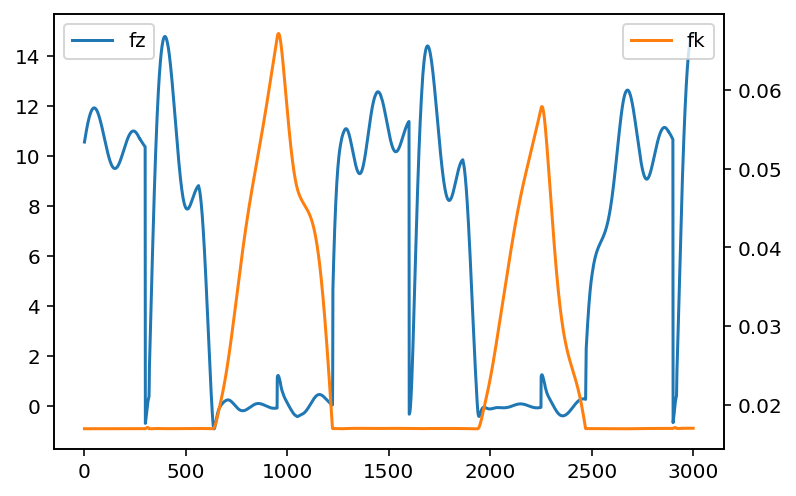

In [16]:
# # s = slice(1000, 3000)
# s = slice(0, -1)
# plt.plot(F_z[s, :], color='C0', label='fz')
# plt.legend(loc='upper left')
# tx = plt.twinx()
# tx.plot(forward_k[s, 2], color='C1', label='fk')
# tx.legend(loc='upper right')

s = slice(1000, 4000)
# s = slice(0, -1)
plt.plot(reader.data['fz'][s, 2], color='C0', label='fz')
plt.legend(loc='upper left')
tx = plt.twinx()
tx.plot(reader.data['fk'][s, 2], color='C1', label='fk')
tx.legend(loc='upper right');

In [19]:
mass = np.sum([i.mass for i in robot.pin_robot.model.inertias])
Fz = 9.81 * mass / 4.

vicon = thread_head.vicon.get_state('solo8v2/solo8v2')
q = np.hstack((vicon[0], head.get_sensor('joint_positions')))
v = np.hstack((vicon[1], head.get_sensor('joint_velocities')))

h = robot.pin_robot.nle(q, v)

robot.pin_robot.computeJointJacobians(q)

rhs = np.zeros(14)
f = np.zeros((4, 3))
idx, F = robot.get_force()

endeff_ids = []
for i in range(4):
    endeff_ids += [robot.pin_robot.model.getFrameId(robot.endeff_names[i])]

print(endeff_ids)
for i in range(4):
    f[i] = -F[idx.index(endeff_ids[i])][:3]

STtau = np.zeros(14)
STtau[6:] = thread_head.active_controllers[0].tau

rhs += STtau

for i in range(4):
    frame_id = robot.pin_robot.model.getFrameId(robot.endeff_names[i])

    print(frame_id)
    robot.pin_robot.framePlacement(q, index=frame_id)

    J = robot.pin_robot.getFrameJacobian(
        frame_id=frame_id, rf_frame=pin.ReferenceFrame.LOCAL_WORLD_ALIGNED)
    rhs += J[:3].T @ f[i]

rhs - h

[7, 13, 19, 25]


ValueError: 13 is not in list

# Unused

In [ ]:
'''
class CentroidalController:
    def __init__(self, head, vicon_name, mu, kp, kd, kc, dc, kb, db):
        self.set_k(kp, kd)
        self.robot = Solo8Config.buildRobotWrapper()
        self.vicon_name = vicon_name

        self.x_com = [0.0, 0.0, 0.20]
        self.xd_com = [0.0, 0.0, 0.0]

#         self.x_des = np.array([ 
#              0.2, 0.142, 0.015,  0.2, -0.142,  0.015,
#             -0.2, 0.142, 0.015, -0.2, -0.142,  0.015
#         ])
        self.x_des = np.array([ 
            0.142, 0.015, -0.142,  0.015,
            0.142, 0.015, -0.142,  0.015
        ])
        
        self.xd_des = np.array(4*[0., 0.])

        self.x_ori = [0., 0., 0., 1.]
        self.x_angvel = [0., 0., 0.]
        self.cnt_array = 4*[1,]
        
        self.w_com = np.zeros(6)
        
        q_init = np.zeros(15)
        q_init[7] = 1
        self.centrl_pd_ctrl = mim_control_cpp.CentroidalPDController()
        self.centrl_pd_ctrl.initialize(2.5, np.diag(self.robot.mass(q_init)[3:6, 3:6]))

        self.force_qp = mim_control_cpp.CentroidalForceQPController()
        self.force_qp.initialize(4, mu, np.array([5e5, 5e5, 5e5, 1e6, 1e6, 1e6]))
                
        root_name = 'universe'
        endeff_names = ['FL_ANKLE', 'FR_ANKLE', 'HL_ANKLE', 'HR_ANKLE']
        self.imp_ctrls = [mim_control_cpp.ImpedanceController() for eff_name in endeff_names]
        for i, c in enumerate(self.imp_ctrls):
            c.initialize(self.robot.model, root_name, endeff_names[i])
        
        self.kc = np.array(kc)
        self.dc = np.array(dc)
        self.kb = np.array(kb)
        self.db = np.array(db)
                
        self.joint_positions = head.get_sensor('joint_positions')
        self.joint_velocities = head.get_sensor('joint_velocities')
        self.slider_positions = head.get_sensor('slider_positions')
        self.imu_gyroscope = head.get_sensor('imu_gyroscope')

    def set_k(self, kp, kd):
        self.kp = 4 * [kp, kp, kp, 0, 0, 0]
        self.kd = 4 * [kd, kd, kd, 0, 0, 0]

    def warmup(self, thread):
        thread.vicon.bias_position(self.vicon_name)
        self.zero_sliders = self.slider_positions.copy()

    def get_base(self, thread):
        base_pos, base_vel = thread.vicon.get_state(self.vicon_name)
        base_vel[3:] = self.imu_gyroscope
        return base_pos, base_vel
    
    def run(self, thread):
        base_pos, base_vel = self.get_base(thread)

        self.q = np.hstack([base_pos, self.joint_positions])
        self.dq = np.hstack([base_vel, self.joint_velocities])

        self.w_com[:] = 0
        
        self.centrl_pd_ctrl.run(
            self.kc, self.dc, self.kb, self.db,
            self.q[:3], self.x_com, self.dq[:3], self.xd_com,
            self.q[3:7], self.x_ori, self.dq[3:6], self.x_angvel
        )
        
        self.w_com[2] = 9.81 * Solo12Config.mass
        self.w_com += self.centrl_pd_ctrl.get_wrench()
        
        if hasattr(self, 'update_w_com'):
            self.update_w_com(thread)
        
        # distrubuting forces to the active end effectors
        pin_robot = self.robot
        pin_robot.framesForwardKinematics(self.q)
        com = self.com = pin_robot.com(self.q)
        rel_eff = np.array([
            pin_robot.data.oMf[i].translation - com for i in Solo12Config.end_eff_ids
        ]).reshape(-1)
                
        ext_cnt_array = [1., 1., 1., 1.]
        self.force_qp.run(self.w_com, rel_eff, ext_cnt_array)
        self.F = self.force_qp.get_forces()
        
        if hasattr(self, 'update_F'):
            self.update_F(thread)
        
        # passing forces to the impedance controller
        self.tau = np.zeros(18)
        for i, c in enumerate(self.imp_ctrls):
            c.run(self.q, self.dq,
                 np.array(self.kp[6*i:6*(i+1)]),
                 np.array(self.kd[6*i:6*(i+1)]),
                 1.,
                 pin.SE3(np.eye(3), np.array(self.x_des[3*i:3*(i+1)])),
                 pin.Motion(self.xd_des[3*i:3*(i+1)], np.zeros(3)),
                 pin.Force(self.F[3*i:3*(i+1)], np.zeros(3))
             )

            self.tau += c.get_torques()
                
        head.set_control('ctrl_joint_torques', self.tau[6:])
'''